In [1]:
import numpy as np
import pandas as pd
from numba import njit
from scipy.stats import norm, halfnorm
import seaborn as sns
import matplotlib.pyplot as plt

import bayesflow as beef
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.models import Sequential

import sys
sys.path.append("../src/")
from priors import sample_eta, sample_random_walk
from likelihood import sample_softmax_rl
from context import generate_context
from configurator import configure_input

/Users/lschumacher/miniconda3/envs/beef/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Suppress scientific notation for floats
np.set_printoptions(suppress=True)
# Configure rng
RNG = np.random.default_rng()

In [3]:
TRAIN_NETWORK = True

In [4]:
LOCAL_PARAM_LABELS = ("Learning rate", "Sensitivity")
LOCAL_PARAM_NAMES = (r"$\alpha$", r"$\tau$")

FONT_SIZE_1 = 16
FONT_SIZE_2 = 14
FONT_SIZE_3 = 12

import matplotlib
matplotlib.rcParams['font.serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "serif"

## Read Empiric Data

In [5]:
emp_data = pd.read_csv("../data/data_fontanesi_prep.csv")
emp_data.f_cor = emp_data.f_cor / 60
emp_data.f_inc = emp_data.f_inc / 60

## Exemplar Trajectory

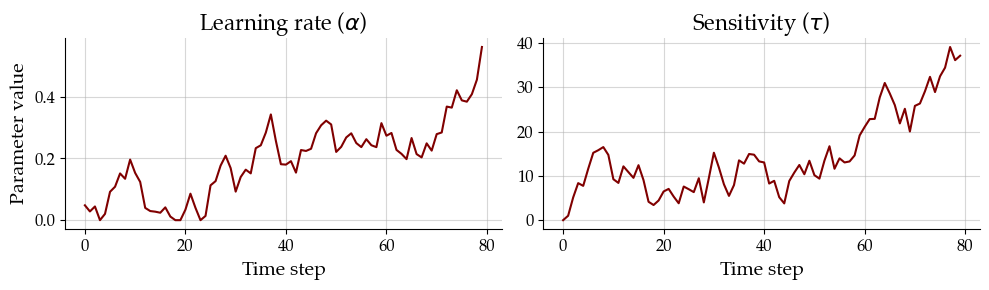

In [6]:
eta = sample_eta()
theta = sample_random_walk(eta)
time = np.arange(theta.shape[0])
fig, axarr = plt.subplots(1, 2, figsize=(10, 3))
for i, ax in enumerate(axarr.flat):
    if i == 7:
        break
    ax.grid(alpha=0.5)
    ax.plot(
        time,
        theta[:, i],
        color='maroon'
    )
    ax.set_title(f'{LOCAL_PARAM_LABELS[i]} ({LOCAL_PARAM_NAMES[i]})', fontsize=FONT_SIZE_1)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    if i == 0 or i == 4:
        ax.set_ylabel("Parameter value", fontsize=FONT_SIZE_2)
    ax.set_xlabel("Time step", fontsize=FONT_SIZE_2)

sns.despine()
fig.tight_layout()

## Generative Model

### Prior

In [7]:
prior = beef.simulation.TwoLevelPrior(
    hyper_prior_fun=sample_eta,
    local_prior_fun=sample_random_walk,
)

### Context

In [8]:
context = beef.simulation.ContextGenerator(
    batchable_context_fun=generate_context,
)

### Likelihood

In [9]:
likelihood = beef.simulation.Simulator(
    simulator_fun=sample_softmax_rl,
    context_generator=context,
)

### Simulator

In [10]:
model = beef.simulation.TwoLevelGenerativeModel(
    prior=prior,
    simulator=likelihood,
    name="non-stationary_softmax_rl",
)

INFO:root:Performing 2 pilot runs with the non-stationary_softmax_rl model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 80, 2)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 80)
INFO:root:Shape of hyper_prior_draws batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:Shape of local_prior_draws batch after 2 pilot simulations: (batch_size = 2, 80, 2)
INFO:root:No shared_prior_draws provided.
INFO:root:Could not determine shape of simulation batchable context. Type appears to be non-array: <class 'list'>,                                    so make sure your input configurator takes care of that!
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional prior non-batchable context provided.


## Neural Approximator

In [11]:
approximator_settings = {
    "lstm1_hidden_units": 512,
    "lstm2_hidden_units": 256,
    "lstm3_hidden_units": 128,
    "trainer": {
        "max_to_keep": 1,
        "default_lr": 5e-4,
        "memory": False,
    },
    "local_amortizer_settings": {
        "num_coupling_layers": 8,
        "coupling_design": 'interleaved'
    },
    "global_amortizer_settings": {
        "num_coupling_layers": 6,
        "coupling_design": 'interleaved'
    },
}

In [12]:
summary_network = beef.networks.HierarchicalNetwork(
    [
        Sequential(
            [
                Bidirectional(LSTM(approximator_settings["lstm1_hidden_units"], return_sequences=True)),
                Bidirectional(LSTM(approximator_settings["lstm2_hidden_units"], return_sequences=True)),
            ]
        ),
        Sequential(
            [
                Bidirectional(LSTM(approximator_settings["lstm3_hidden_units"]))
            ]
        )
    ]
)

In [13]:
local_network = beef.amortizers.AmortizedPosterior(
    beef.networks.InvertibleNetwork(
        num_params=2,
        **approximator_settings.get("local_amortizer_settings")
    )
)
global_network = beef.amortizers.AmortizedPosterior(
    beef.networks.InvertibleNetwork(
        num_params=2,
        **approximator_settings.get("global_amortizer_settings")
    )
)

In [14]:
amortizer = beef.amortizers.TwoLevelAmortizedPosterior(
    local_amortizer=local_network,
    global_amortizer=global_network,
    summary_net=summary_network
)
trainer = beef.trainers.Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=configure_input,
    **approximator_settings.get("trainer"),
    checkpoint_path="../checkpoints/non-stationary_softmax_rl"
)

INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


## Training

In [15]:
if TRAIN_NETWORK:
    history = trainer.train_online(
        epochs=100,
        iterations_per_epoch=1000,
        batch_size=32
    )
    loss_plot = beef.diagnostics.plot_losses(trainer.loss_history.get_plottable())
else:
    loss_plot = beef.diagnostics.plot_losses(trainer.loss_history.get_plottable())

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]